In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.poly import create_vertice
import re
from datetime import datetime, timedelta

from matplotlib.animation import FuncAnimation
from numpy import arange, isnan, meshgrid, ones

from py_eddy_tracker import start_logger
from py_eddy_tracker.data import get_demo_path
from py_eddy_tracker.dataset.grid import GridCollection, _fit_circle_path
from py_eddy_tracker.observations.observation  import EddiesObservations
from py_eddy_tracker.gui import GUI_AXES
from py_eddy_tracker.generic import uniform_resample, coordinates_to_local
from py_eddy_tracker.poly import create_vertice, poly_area, visvalingam

from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.cm as cm

from typing import List, Tuple

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from py_eddy_tracker.eddy_feature import Amplitude, Contours, detect_local_minima_
import time
from os import walk
from datetime import datetime

In [3]:
class eddy_detection():
    def __init__(self, dataset_path: str, lat: list, lon: list, height: str):
        self.path = dataset_path
        self.height = height
        self.data: List[Tuple] = self.load_data()
        self.hours_since_start_list: list = []
        self.grid_list: List[RegularGridDataset] = []
        self.days_list: list = [] 
        self.lat: list = lat
        self.lon: list = lon
        self.anticyclonic_list: list = []
        self.cyclonic_list: list = []
        return None
    
    def start_axes(self, title):
        fig = plt.figure(figsize=(13, 5))
        ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
        ax.set_xlim(self.lon[0], self.lon[1]), ax.set_ylim(self.lat[0], self.lat[1])
        ax.set_aspect("equal")
        ax.set_title(title, weight="bold")
        return ax


    def update_axes(self, ax, mappable=None):
        ax.grid()
        if mappable:
            plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

    def load_data(self):
        grid_collection = GridCollection.from_netcdf_cube(
            get_demo_path(self.path),
            "LONGITUDE",
            "LATITUDE",
            "TIME",
            heigth=self.height)
        return grid_collection.datasets
    
    def create_list_dataset(self, days_list: List):
        self.days_list = days_list
        for day in self.days_list:
            hours, g = self.data[day-1]
            g.vars[self.height] = np.ma.array(g.vars[self.height], mask=np.isnan(g.vars['ssh']))
            g.add_uv(self.height)
            self.hours_since_start_list.append(hours)
            self.grid_list.append(g)

    def plot_graph(self, days:list):
        for day in days:
            ax = self.start_axes("SSH (m)")
            m = self.grid_list[day-1].display(ax, self.height, vmin=-1, vmax=1, cmap="RdBu_r")
            self.update_axes(ax, m)
        return None
    def detect_eddies(self, min_pixel : int = 30):
        for day in self.days_list:
            date = datetime(1950, 1 , 1) + timedelta(hours=int(self.hours_since_start_list[day-1])) 
            a, c = self.grid_list[day-1].eddy_identification(self.height, "u", "v", date, 0.002, pixel_limit=(min_pixel, 2000), shape_error=70)
            self.anticyclonic_list.append(a)
            self.cyclonic_list.append(c)
        return None
    def plot_detected(self, days:list):
        for day in days:
            ax = self.start_axes("Detected Eddies")
            self.anticyclonic_list[day - 1].display(
                ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-70
            )
            self.cyclonic_list[day - 1].display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-70)
            ax.legend()
            self.update_axes(ax)
        return None

In [4]:
month_days = {1: 31, 2: 28, 3: 31, 4: 30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11: 30, 12: 31}
a_true_list = []
c_true_list = []
a_true_alg_list = []
c_true_alg_list = []
a_pred_list = []
c_pred_list = []
for j in range(9, 20):
    for i in range(1, 13):
        for k in range(month_days[i]):
            date = datetime(2000 + j, i, k+1)
            a_true = EddiesObservations()
            a_true = a_true.load_from_netcdf(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/south_atlantic/anticyclonic/Anticyclonic_%Y%m%d.nc"))
            c_true = EddiesObservations()
            c_true = c_true.load_from_netcdf(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/south_atlantic/cyclonic/Cyclonic_%Y%m%d.nc"))
            a_true_alg = EddiesObservations()
            a_true_alg = a_true_alg.load_from_netcdf(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/south_atlantic/anticyclonic_alg/Anticyclonic_%Y%m%d.nc"))
            c_true_alg = EddiesObservations()
            c_true_alg = c_true_alg.load_from_netcdf(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/south_atlantic/cyclonic_alg/Cyclonic_%Y%m%d.nc"))
            a_pred = EddiesObservations()
            a_pred = a_pred.load_from_netcdf(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/south_atlantic/anticyclonic_pred/Anticyclonic_%Y%m%d.nc"))
            c_pred = EddiesObservations()
            c_pred = c_pred.load_from_netcdf(date.strftime("/albedo/work/user/ssunar/for_paper/obs_data/south_atlantic/cyclonic_pred/Cyclonic_%Y%m%d.nc"))
            a_true_list.append(a_true)
            c_true_list.append(c_true)
            a_true_alg_list.append(a_true_alg)
            c_true_alg_list.append(c_true_alg)
            a_pred_list.append(a_pred)
            c_pred_list.append(c_pred)

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tracker version '0+unknown' but software version is '3.6'
File was created with py-eddy-tr

In [5]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    ax.set_xlim(-70, 0), ax.set_ylim(-60, -20)
    ax.set_aspect("equal")
    ax.set_title(title, weight="bold")
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

In [6]:
a_true_obj = EddiesObservations.concatenate(a_true_list)
c_true_obj = EddiesObservations.concatenate(c_true_list)
a_pred_obj = EddiesObservations.concatenate(a_pred_list)
c_pred_obj = EddiesObservations.concatenate(c_pred_list)

In [7]:
a_true_alg_obj = EddiesObservations.concatenate(a_true_alg_list)
c_true_alg_obj = EddiesObservations.concatenate(c_true_alg_list)

In [8]:
true_obj = a_true_obj.merge(c_true_obj)
true_alg_obj = a_true_alg_obj.merge(c_true_alg_obj)
pred_obj = a_pred_obj.merge(c_pred_obj)

In [9]:
np.size(true_obj.amplitude)

1124953

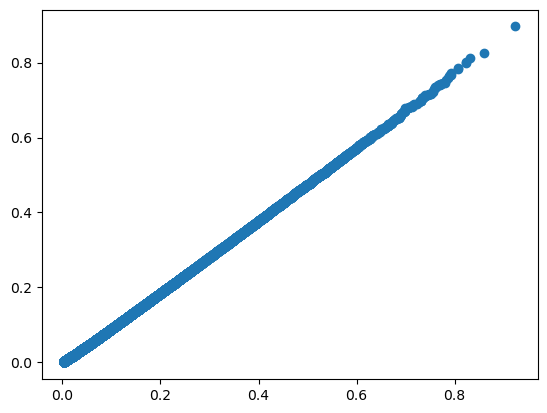

In [13]:
plt.scatter(np.sort(true_obj.amplitude), np.sort(true_alg_obj.amplitude[:1124953]))

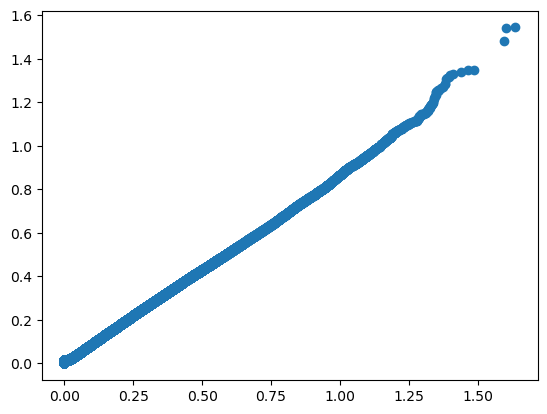

In [14]:
plt.scatter(np.sort(true_obj.speed_average), np.sort(true_alg_obj.speed_average[:1124953]))

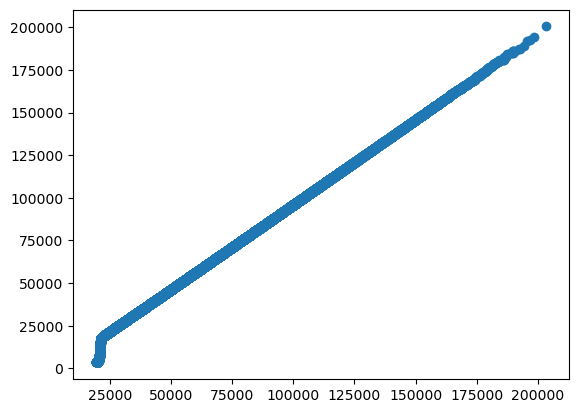

In [15]:
plt.scatter(np.sort(true_obj.radius_e), np.sort(true_alg_obj.radius_e[:1124953]))

In [31]:
a_true_obj_30 = EddiesObservations.concatenate(a_true_list[0:31])
a_true_alg_obj_30 = EddiesObservations.concatenate(a_true_alg_list[0:31])

In [34]:
a_true_alg_obj_30

| 188 observations from 4018.0 to 4018.0 (1.0 days, ~188 obs/day)
    |   Speed area      : 2.29 Mkm²/day
    |   Effective area  : 2.29 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :      17.02     23.40     19.68     11.70      5.32     13.30      9.57
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      4.79     32.45     25.53     11.70     16.49      9.04      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.00      4.79     32.45     25.53     11.70     16.49      9.04      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00    -15.00     15.00     60.00     90.00
        Percent of eddies         :       0.00    100.00      0.00      0.00      0.00
        Percent of speed area     :       0.00    100.00      0.00      0.00      0.00
        Percent of effective area :       0.00    100.00      0.00      0.00      0.00
        Mean speed radius (km)    :        nan     59.61       nan       nan       nan
        Mean effective radius (km):        nan     59.61       nan       nan       nan
        Mean amplitude (cm)       :        nan      4.40       nan       nan       nan

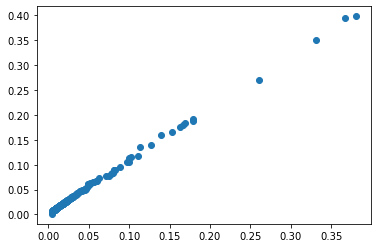

In [35]:

plt.scatter(np.sort(a_true_obj_30.amplitude[0:188]), np.sort(a_true_alg_obj_30.amplitude))

In [9]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5), facecolor=(1, 1, 1))
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    ax.set_xlim(-70, 0), ax.set_ylim(-60, -20)
    ax.set_aspect("equal")
    ax.set_title(title)
    return fig, ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.95, 0.05, 0.01, 0.9]))

In [10]:
deg = 1

In [18]:
#seperated a and c only for count

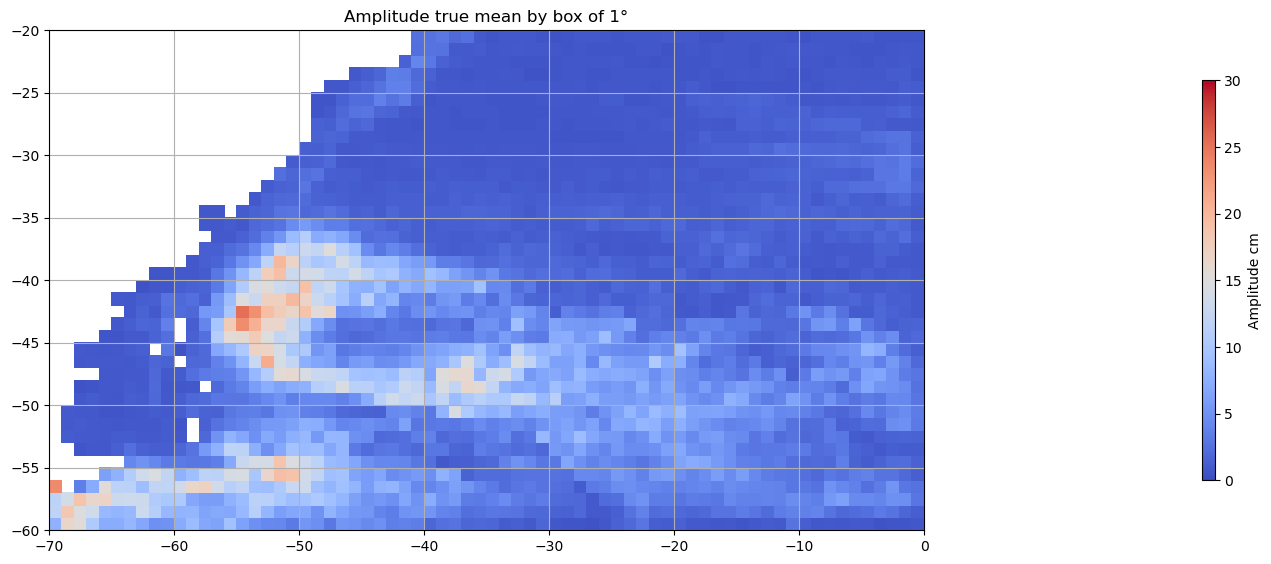

In [35]:
fig, ax = start_axes("Amplitude true mean by box of %s°" % deg)
g = true_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "amplitude")
m = g.display(ax, name="amplitude", vmin=0, vmax=30, factor=100)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Amplitude cm")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Amplitude true mean.png", bbox_inches='tight', dpi = 300)

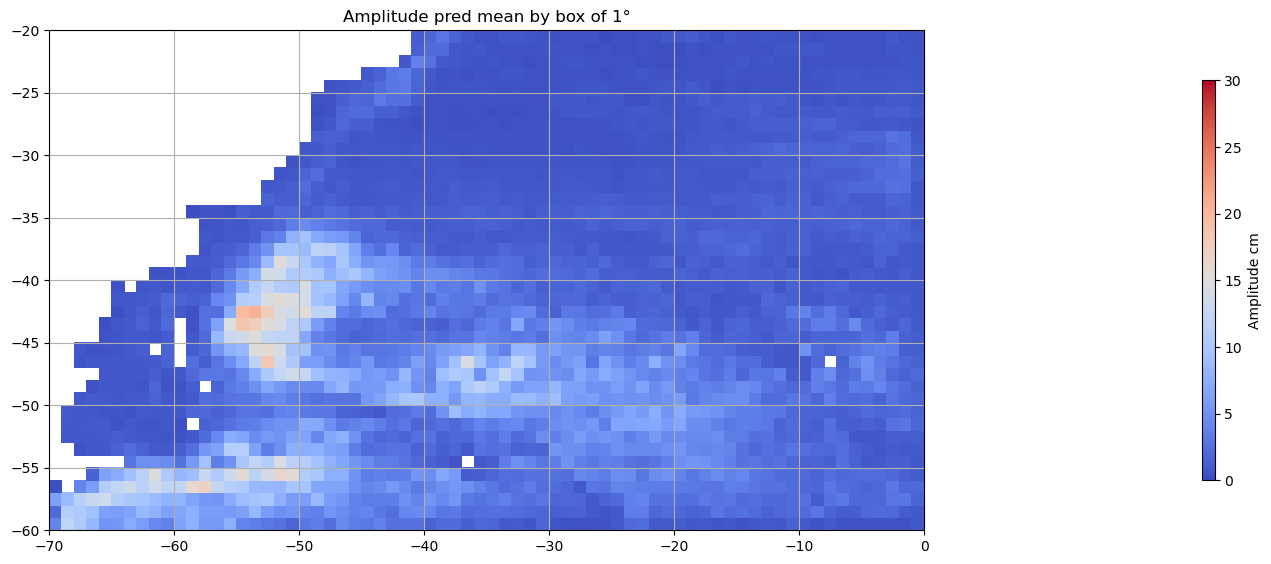

In [36]:
fig, ax = start_axes("Amplitude pred mean by box of %s°" % deg)
g = pred_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "amplitude")
m = g.display(ax, name="amplitude", vmin=0, vmax=30, factor=100)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Amplitude cm")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Amplitude pred mean.png", bbox_inches='tight', dpi = 300)

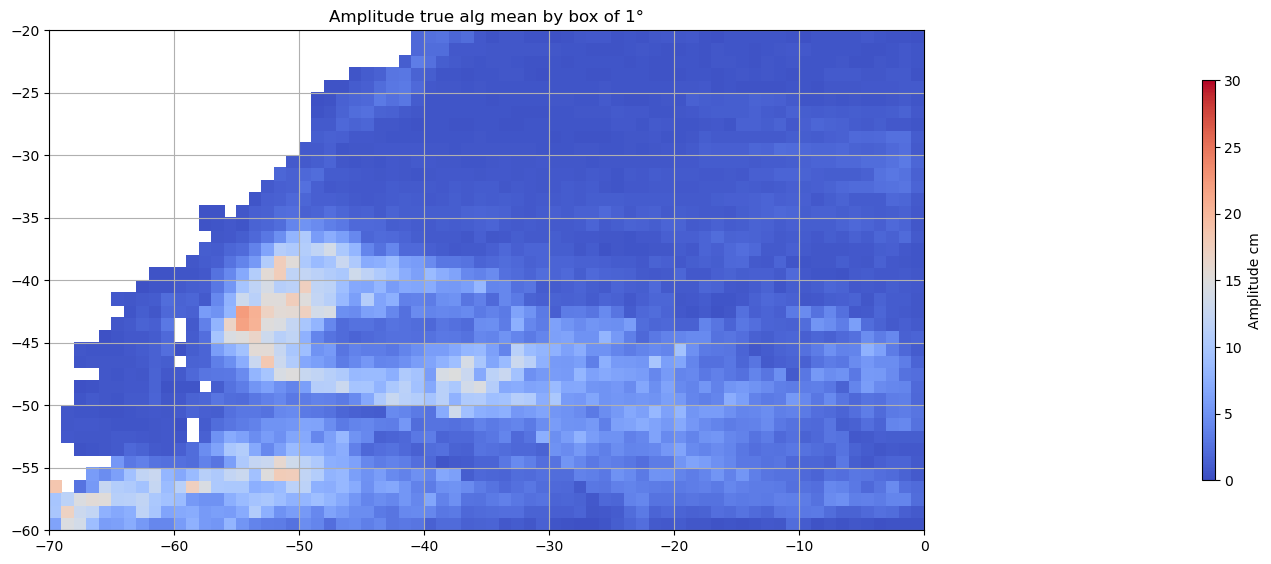

In [37]:
fig, ax = start_axes("Amplitude true alg mean by box of %s°" % deg)
g = true_alg_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "amplitude")
m = g.display(ax, name="amplitude", vmin=0, vmax=30, factor=100)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Amplitude cm")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Amplitude true alg mean.png", bbox_inches='tight', dpi = 300)

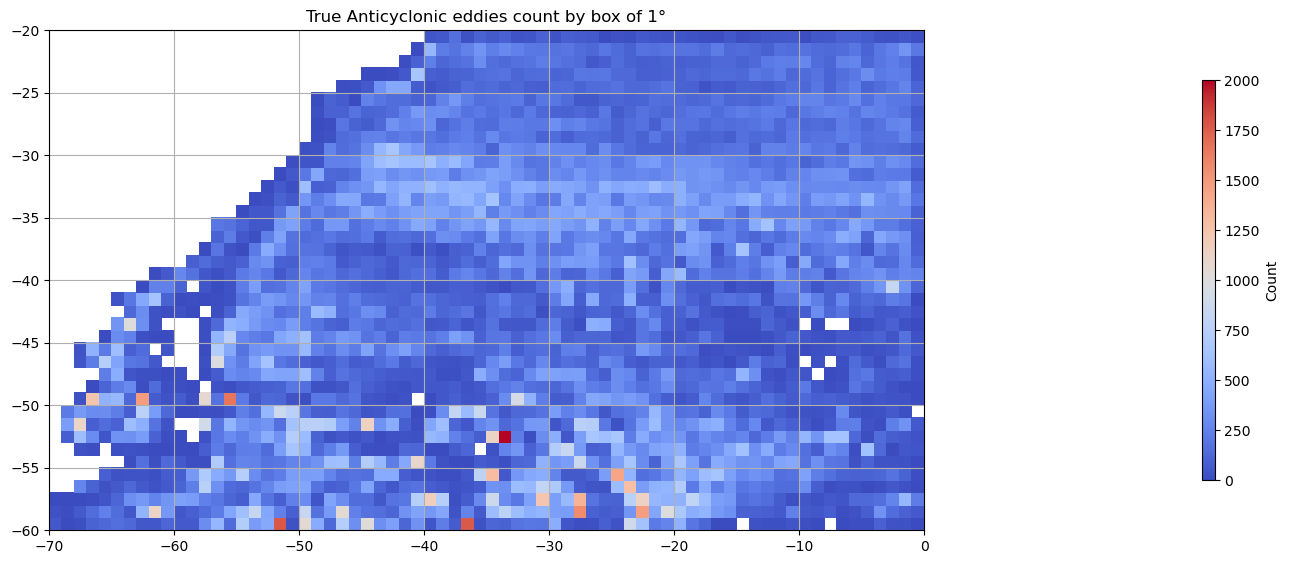

In [38]:
fig, ax = start_axes("True Anticyclonic eddies count by box of %s°" % deg)
g = a_true_obj.grid_count(bins = ((-70, 2, deg), (-60, -18, deg)), center = True)
m = g.display(ax, name="count", vmin=0, vmax=2000, factor=1)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Count")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "True Anticyclonic eddies count.png", bbox_inches='tight', dpi = 300)

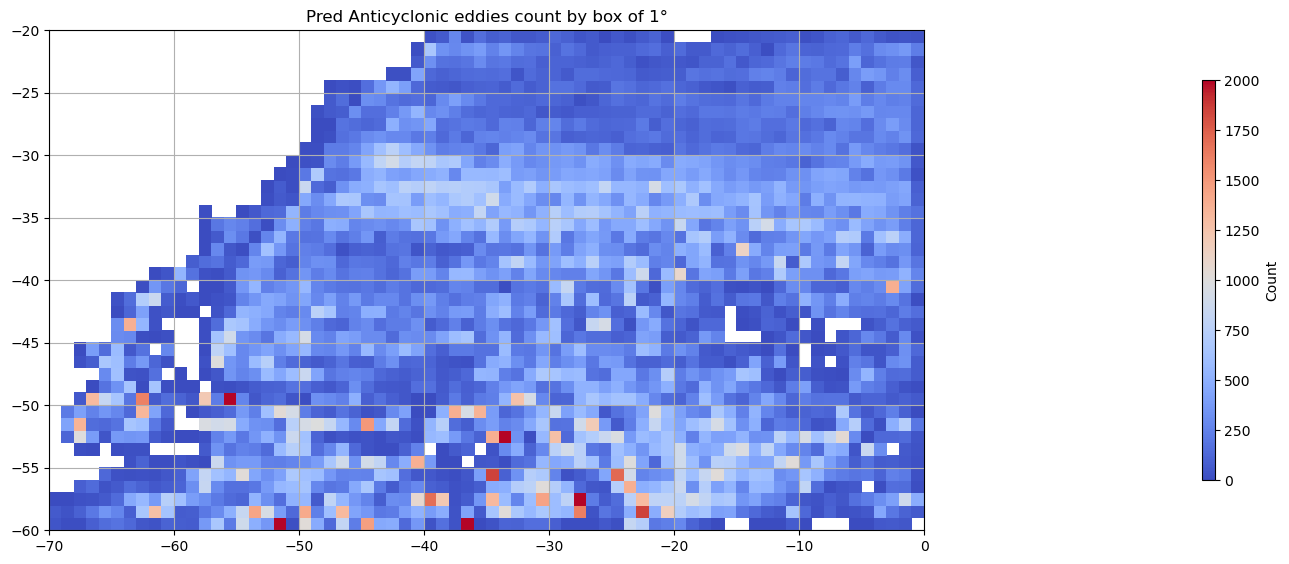

In [39]:
fig, ax = start_axes("Pred Anticyclonic eddies count by box of %s°" % deg)
g = a_pred_obj.grid_count(bins = ((-70, 2, deg), (-60, -18, deg)), center = True)
m = g.display(ax, name="count", vmin=0, vmax=2000, factor=1)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Count")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Pred Anticyclonic eddies count.png", bbox_inches='tight', dpi = 300)

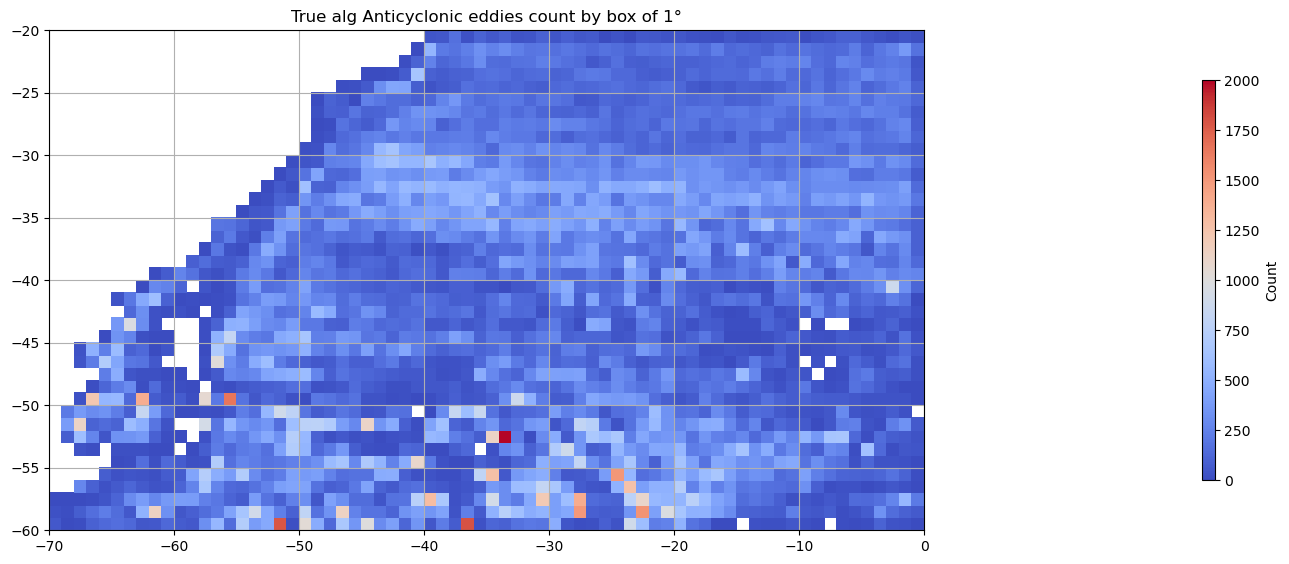

In [40]:
fig, ax = start_axes("True alg Anticyclonic eddies count by box of %s°" % deg)
g = a_true_alg_obj.grid_count(bins = ((-70, 2, deg), (-60, -18, deg)), center = True)
m = g.display(ax, name="count", vmin=0, vmax=2000, factor=1)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Count")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "True alg Anticyclonic eddies count.png", bbox_inches='tight', dpi = 300)

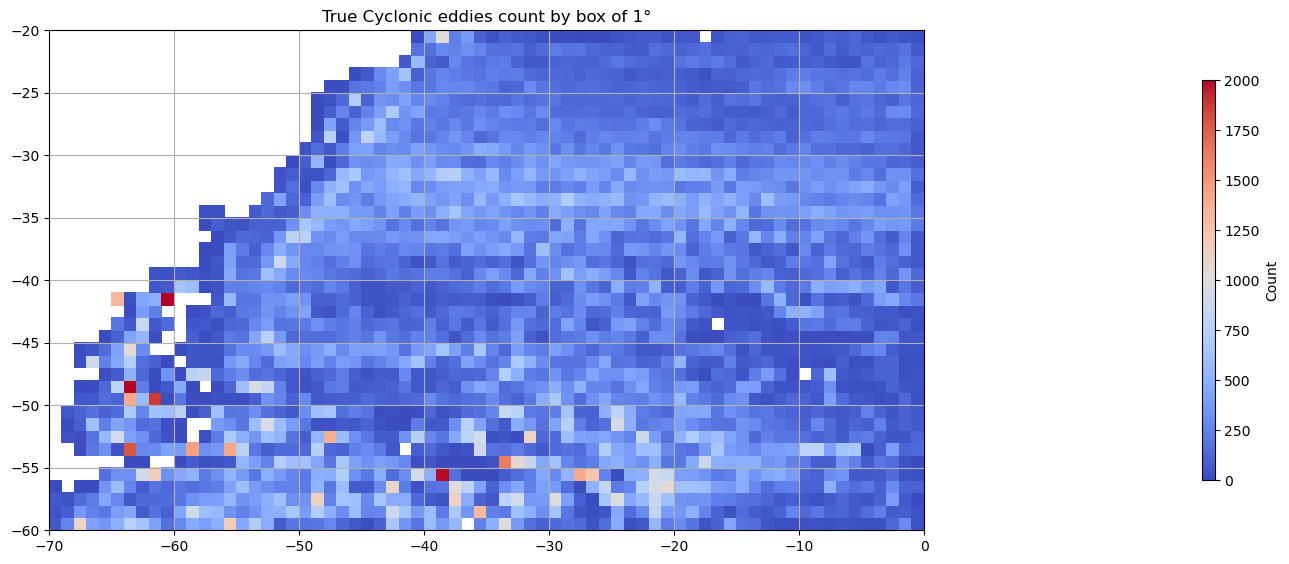

In [43]:
fig, ax = start_axes("True Cyclonic eddies count by box of %s°" % deg)
g = c_true_obj.grid_count(bins = ((-70, 2, deg), (-60, -18, deg)), center = True)
m = g.display(ax, name="count", vmin=0, vmax=2000, factor=1)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Count")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "True Cyclonic eddies count.png", bbox_inches='tight', dpi = 300)

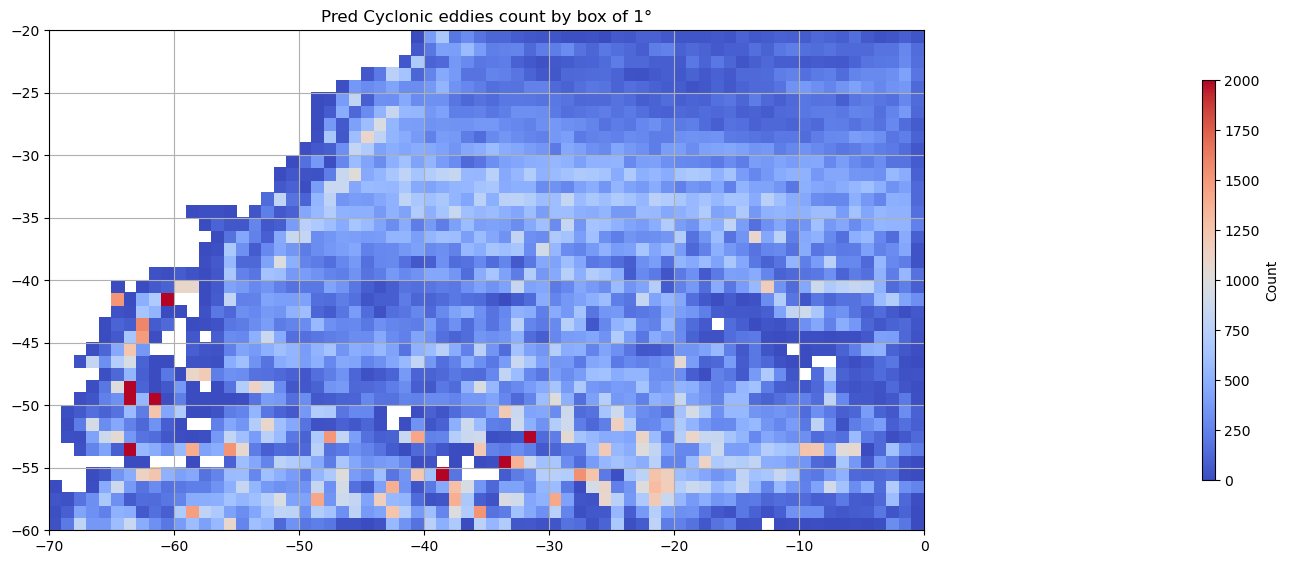

In [11]:
fig, ax = start_axes("Pred Cyclonic eddies count by box of %s°" % deg)
g = c_pred_obj.grid_count(bins = ((-70, 2, deg), (-60, -18, deg)), center = True)
m = g.display(ax, name="count", vmin=0, vmax=2000, factor=1)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Count")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Pred Cyclonic eddies count.png", bbox_inches='tight', dpi = 300)

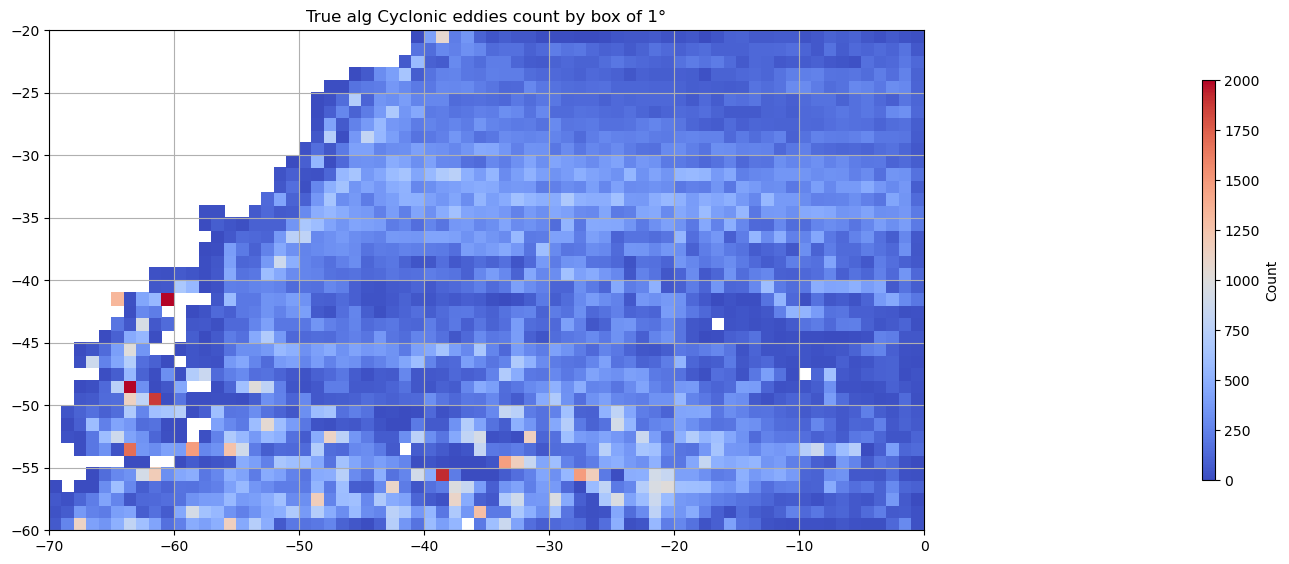

In [12]:
fig, ax = start_axes("True alg Cyclonic eddies count by box of %s°" % deg)
g = c_true_alg_obj.grid_count(bins = ((-70, 2, deg), (-60, -18, deg)), center = True)
m = g.display(ax, name="count", vmin=0, vmax=2000, factor=1)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Count")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "True alg Cyclonic eddies count.png", bbox_inches='tight', dpi = 300)

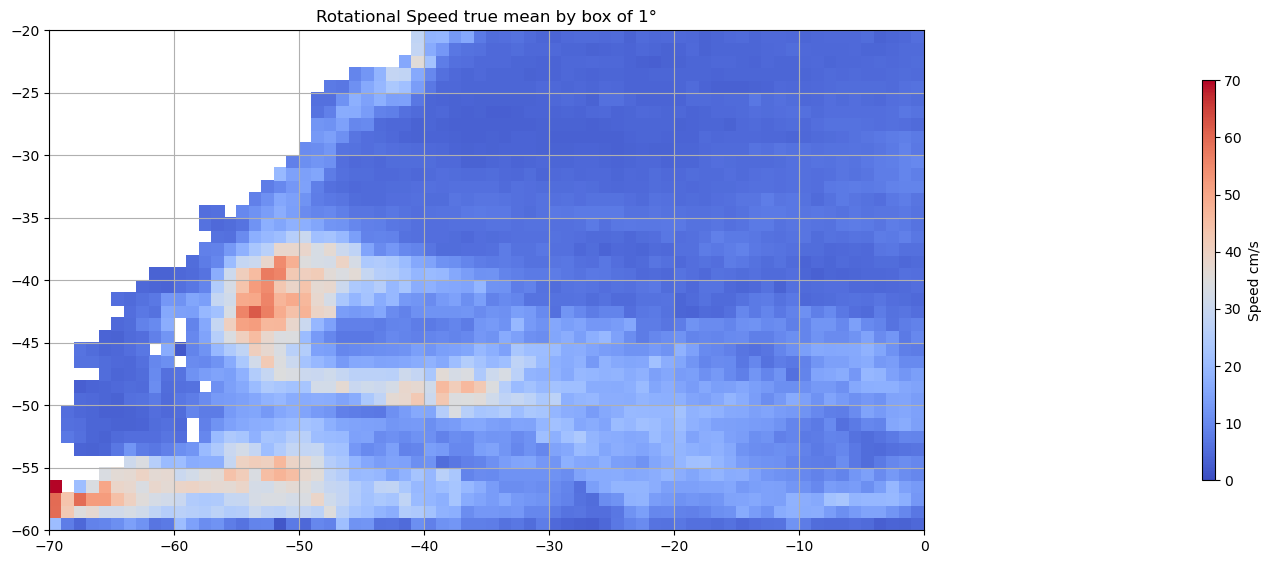

In [46]:

fig, ax = start_axes("Rotational Speed true mean by box of %s°" % deg)
g = true_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "speed_average")
m = g.display(ax, name="speed_average", vmin=0, vmax=70, factor=100)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Speed cm/s")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Rotational Speed true mean.png", bbox_inches='tight', dpi = 300)

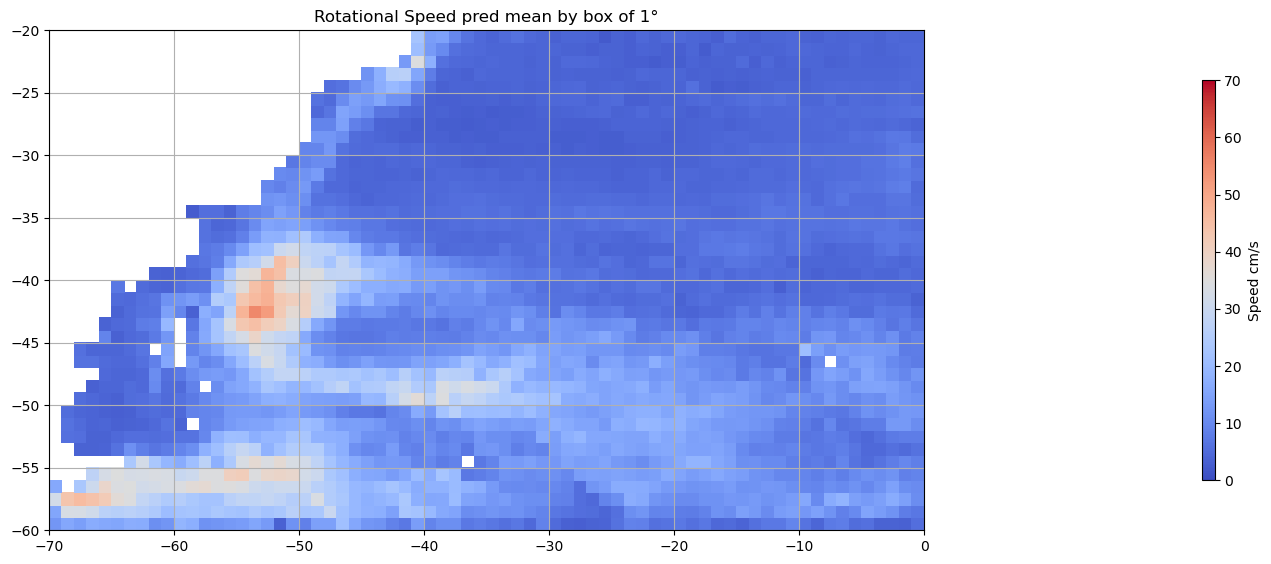

In [47]:
fig, ax = start_axes("Rotational Speed pred mean by box of %s°" % deg)
g = pred_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "speed_average")
m = g.display(ax, name="speed_average", vmin=0, vmax=70, factor=100)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Speed cm/s")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Rotational Speed pred mean.png", bbox_inches='tight', dpi = 300)

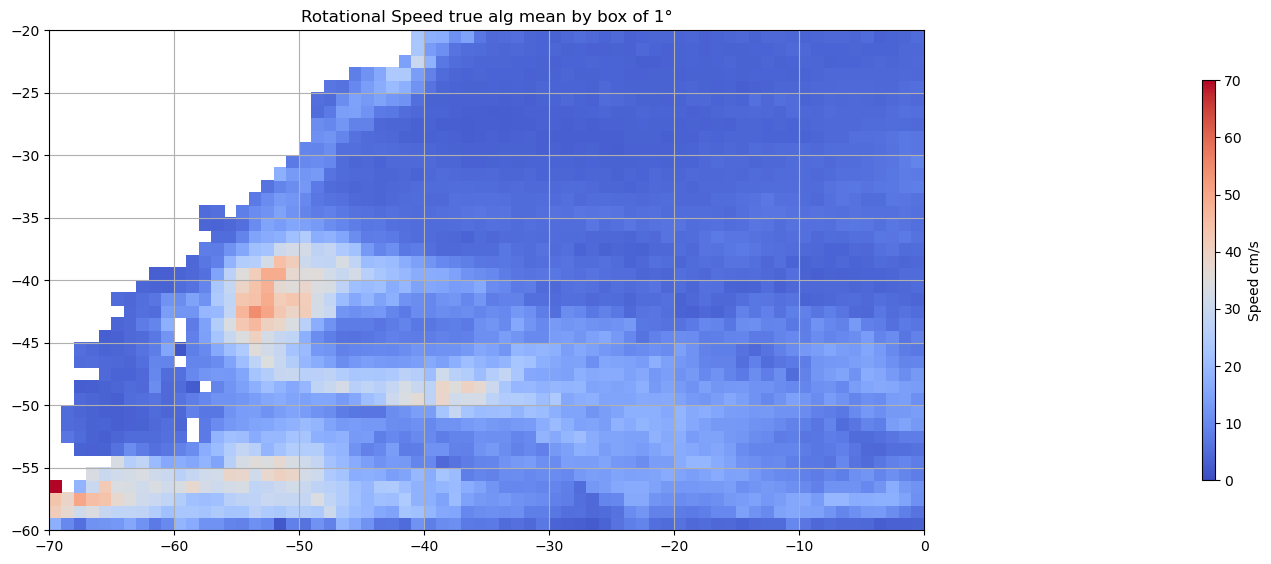

In [48]:

fig, ax = start_axes("Rotational Speed true alg mean by box of %s°" % deg)
g = true_alg_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "speed_average")
m = g.display(ax, name="speed_average", vmin=0, vmax=70, factor=100)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Speed cm/s")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Rotational Speed true alg mean.png", bbox_inches='tight', dpi = 300)

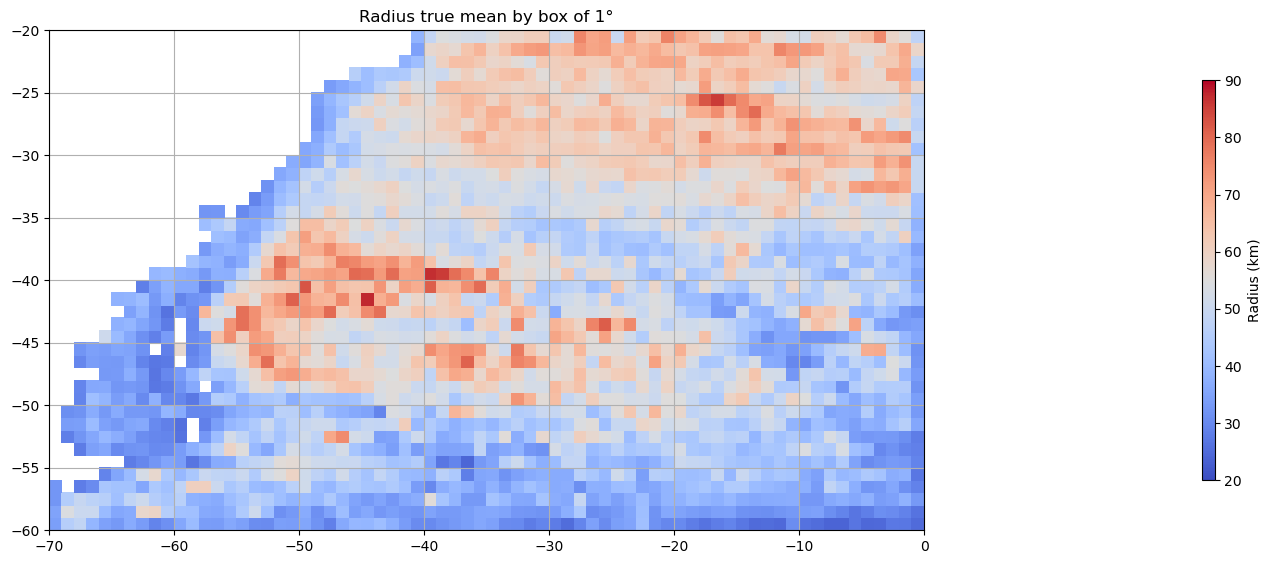

In [49]:
fig, ax = start_axes("Radius true mean by box of %s°" % deg)
g = true_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "radius_e")
m = g.display(ax, name="radius_e", vmin=20, vmax=90, factor=0.001)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Radius (km)")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Radius true mean.png", bbox_inches='tight', dpi = 300)

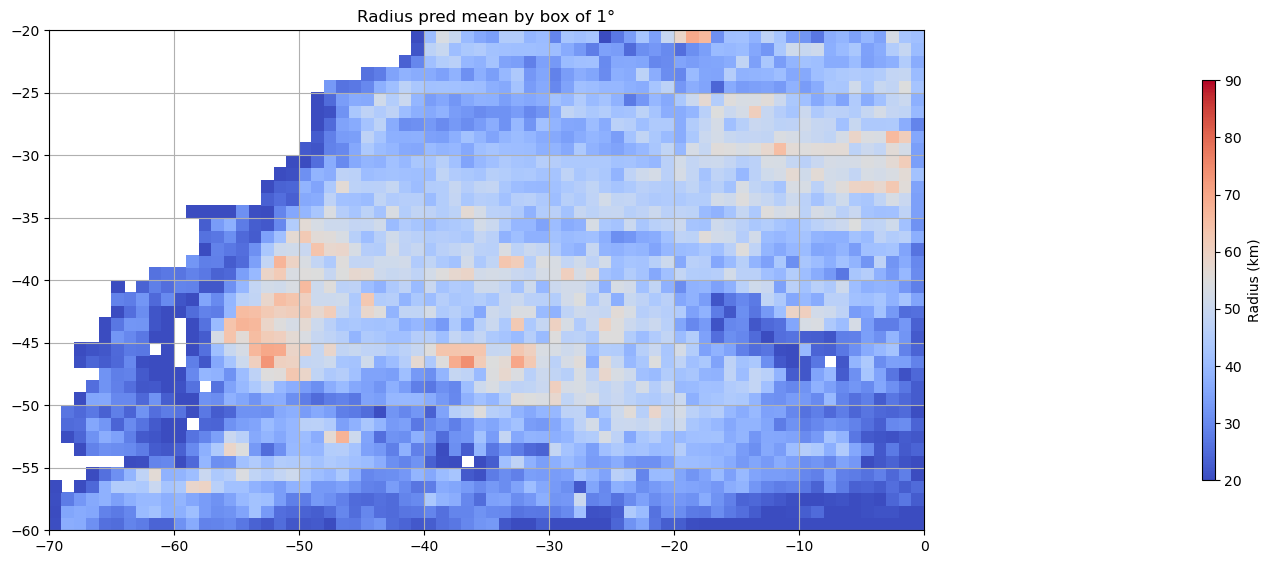

In [50]:
fig, ax = start_axes("Radius pred mean by box of %s°" % deg)
g = pred_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "radius_e")
m = g.display(ax, name="radius_e", vmin=20, vmax=90, factor=0.001)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Radius (km)")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Radius pred mean.png", bbox_inches='tight', dpi = 300)

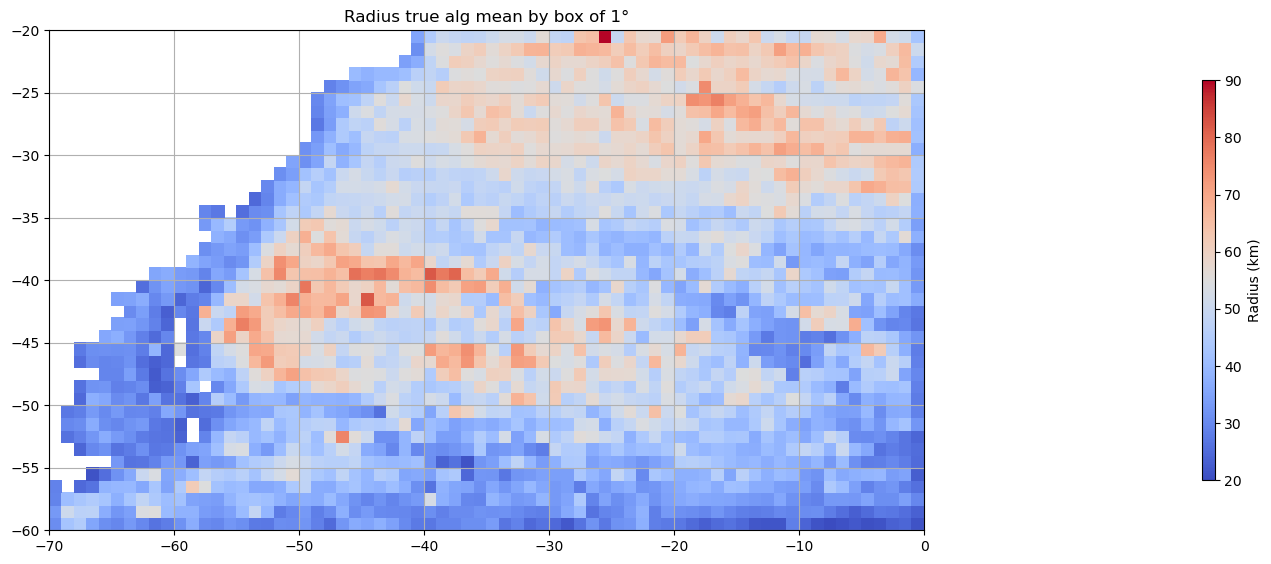

In [51]:
fig, ax = start_axes("Radius true alg mean by box of %s°" % deg)
g = true_alg_obj.grid_stat(((-70, 2, deg), (-60, -18, deg)), "radius_e")
m = g.display(ax, name="radius_e", vmin=20, vmax=90, factor=0.001)
ax.grid()
cb = plt.colorbar(m, cax=ax.figure.add_axes([1.15, 0.2, 0.01, 0.8]))
cb.set_label("Radius (km)")
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Radius true alg mean.png", bbox_inches='tight', dpi = 300)

In [52]:
a_lon_pred = a_pred_obj.parse_varname('lon')
a_lon_true = a_true_obj.parse_varname('lon')

a_lat_pred = a_pred_obj.parse_varname('lat')
a_lat_true = a_true_obj.parse_varname('lat')

a_speed_pred = a_pred_obj.parse_varname('speed_average')
a_speed_true = a_true_obj.parse_varname('speed_average')

a_radius_pred = a_pred_obj.parse_varname('radius_e')
a_radius_true = a_true_obj.parse_varname('radius_e')

# a_quiet_pred = (a_lon_pred > -40)&(a_lon_pred <5)&(a_lat_pred>-40)
# a_good_speed_pred = a_speed_pred < 1000
# a_good_radius_pred = a_radius_pred < 500000

# a_quiet_true = (a_lon_true > -40)&(a_lon_true <5)&(a_lat_true>-40)
# a_good_speed_true = a_speed_true < 1000
# a_good_radius_true = a_radius_true < 500000


bins_value_speed = np.arange(0,1.1,.05)
bins_value_radius = np.arange(0, 200, 10)

In [53]:
c_lon_pred = c_pred_obj.parse_varname('lon')
c_lon_true = c_true_obj.parse_varname('lon')

c_lat_pred = c_pred_obj.parse_varname('lat')
c_lat_true = c_true_obj.parse_varname('lat')

c_speed_pred = c_pred_obj.parse_varname('speed_average')
c_speed_true = c_true_obj.parse_varname('speed_average')

c_radius_pred = c_pred_obj.parse_varname('radius_e')
c_radius_true = c_true_obj.parse_varname('radius_e')

# c_quiet_pred = (c_lon_pred > -40)&(c_lon_pred <5)&(c_lat_pred>-40)
# c_good_speed_pred = c_speed_pred < 1000
# c_good_radius_pred = c_radius_pred < 500000

# c_quiet_true = (c_lon_true > -40)&(c_lon_true <5)&(c_lat_true>-40)
# c_good_speed_true = c_speed_true < 1000
# c_good_radius_true = c_radius_true < 500000


bins_value_speed = np.arange(0,1.1,.05)
bins_value_radius = np.arange(0, 200, 10)

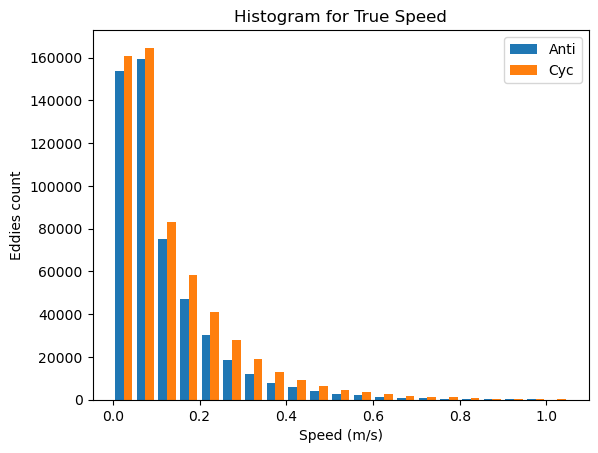

In [73]:
fig, ax = plt.subplots()
ax.set_facecolor((1,1,1))
ax.hist([a_speed_true, c_speed_true], bins = bins_value_speed, width = 0.02, density = False, label = ["Anti", "Cyc"]) #edges
ax.set_title("Histogram for True Speed")
ax.set_xlabel("Speed (m/s)")
ax.set_ylabel("Eddies count")
ax.legend()
fig.patch.set_facecolor((1,1,1))
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Histogram for True Speed.png", bbox_inches='tight', dpi = 300)

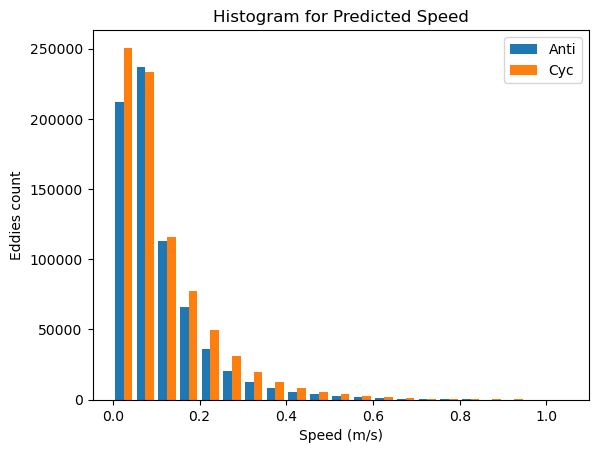

In [79]:
fig, ax = plt.subplots()
ax.set_facecolor((1,1,1))
ax.hist([a_speed_pred, c_speed_pred], bins = bins_value_speed, width = 0.02, density = False, label = ["Anti", "Cyc"]) #edges
ax.set_title("Histogram for Predicted Speed")
ax.set_xlabel("Speed (m/s)")
ax.set_ylabel("Eddies count")
ax.legend()
fig.patch.set_facecolor((1,1,1))
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Histogram for Predicted.png", bbox_inches='tight', dpi = 300)


In [75]:
# fig, ax = plt.subplots()
# ax.set_facecolor((1,1,1))
# ax.hist([a_speed_true, c_speed_true], bins = bins_value_speed, width = 0.02, density = False, label = ["Anti", "Cyc"]) #edges
# ax.set_title("Histogram for True Speed Quiet Region")
# ax.set_xlabel("Speed (m/s)")
# ax.set_ylabel("Eddies count")
# ax.legend()
# fig.patch.set_facecolor((1,1,1))
# fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Histogram for True Speed Quiet Region.png", bbox_inches='tight', dpi = 300)


In [76]:
# fig, ax = plt.subplots()
# ax.set_facecolor((1,1,1))
# ax.hist([a_speed_pred[(a_quiet_pred) & a_good_speed_pred], c_speed_pred[(c_quiet_pred) & c_good_speed_pred]], bins = bins_value_speed, width = 0.02, density = False, label = ["Anti", "Cyc"]) #edges
# ax.set_title("Histogram for Predicted Speed (Anticyclonic) Quiet Region")
# ax.set_xlabel("Speed (m/s)")
# ax.set_ylabel("Eddies count")
# ax.legend()
# fig.patch.set_facecolor((1,1,1))
# fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Histogram for True Speed Quiet Region.png", bbox_inches='tight', dpi = 300)


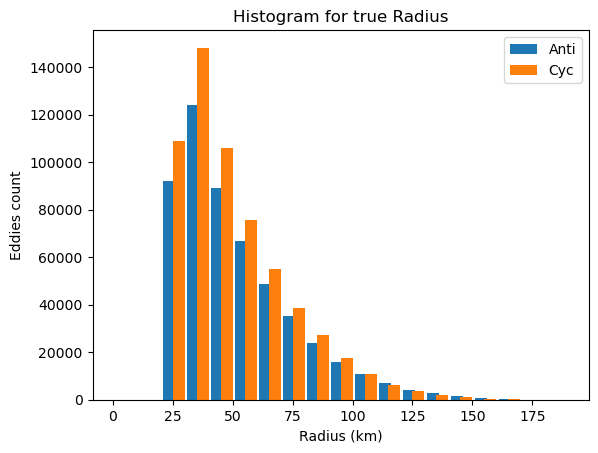

In [77]:
fig, ax = plt.subplots()
ax.set_facecolor((1,1,1))
ax.hist([a_radius_true / 1000, c_radius_true / 1000] , bins = bins_value_radius, width = 5, density = False, label = ["Anti", "Cyc"]) #edges
ax.set_title("Histogram for true Radius")
ax.set_xlabel("Radius (km)")
ax.set_ylabel("Eddies count")
ax.legend()
fig.patch.set_facecolor((1,1,1))
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Histogram for true Radius.png", bbox_inches='tight', dpi = 300)

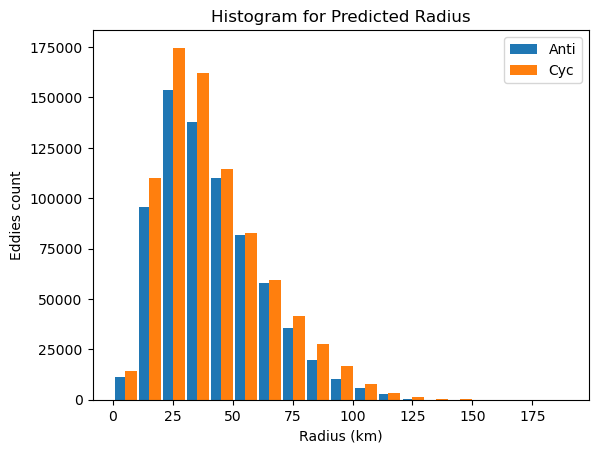

In [78]:
fig, ax = plt.subplots()
ax.set_facecolor((1,1,1))
ax.hist([a_radius_pred / 1000, c_radius_pred / 1000], bins = bins_value_radius, width = 5, density = False, label = ["Anti", "Cyc"]) #edges
ax.set_title("Histogram for Predicted Radius")
ax.set_xlabel("Radius (km)")
ax.set_ylabel("Eddies count")
ax.legend()
fig.patch.set_facecolor((1,1,1))
fig.savefig("/albedo/home/ssunar/CNN_eddy_detection/statistics/img/South_atlantic_" + "Histogram for Predicted Radius.png", bbox_inches='tight', dpi = 300)

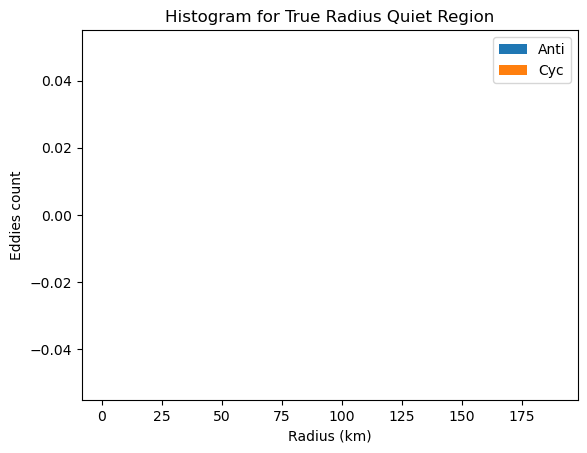

In [58]:
# fig, ax = plt.subplots()
# ax.set_facecolor((1,1,1))
# ax.hist([a_radius_true[(a_quiet_true) & a_good_radius_true] /1000, c_radius_true[(c_quiet_true) & c_good_radius_true] / 1000], bins = bins_value_radius, width = 5, density = False, label = ["Anti", "Cyc"]) #edges
# ax.set_title("Histogram for True Radius Quiet Region")
# ax.set_xlabel("Radius (km)")
# ax.set_ylabel("Eddies count")
# ax.legend()
# fig.patch.set_facecolor((1,1,1))
# #fig.savefig("/home/ollie/ssunar/CNN_eddy_detection/statistics/img/" + "15.png", bbox_inches='tight', dpi = 300)

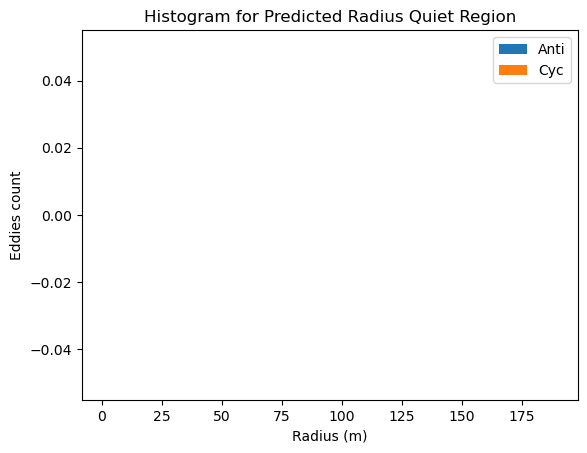

In [59]:
# fig, ax = plt.subplots()
# ax.set_facecolor((1,1,1))
# ax.hist([a_radius_pred[(a_quiet_pred) & a_good_radius_pred] / 1000, c_radius_pred[(c_quiet_pred) & c_good_radius_pred] / 1000], bins = bins_value_radius, width = 5, density = False, label = ["Anti", "Cyc"]) #edges
# ax.set_title("Histogram for Predicted Radius Quiet Region")
# ax.set_xlabel("Radius (m)")
# ax.set_ylabel("Eddies count")
# ax.legend()
# fig.patch.set_facecolor((1,1,1))
# #fig.savefig("/home/ollie/ssunar/CNN_eddy_detection/statistics/img/" + "16.png", bbox_inches='tight', dpi = 300)

In [ ]:
# 1 year done
# quiet and not quiet done
# Speed done
# Radius done
# 2d histogram bin (Pinned)
# https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
# https://pangeo-pyinterp.readthedocs.io/en/latest/auto_examples/ex_binning.html
# Test file for GNN guys


In [190]:
np.percentile(speed_true[(quiet_true) & good_true], [25, 50, 75])

array([0.04341142, 0.06169993, 0.08989266])

In [202]:
len(speed_true[(~quiet_true) & good_true])

3261

In [191]:
np.percentile(speed_pred[(quiet_pred) & good_pred], [25, 50, 75])

array([0.03650774, 0.05892709, 0.08778252])

In [204]:
len(speed_pred[(~quiet_pred) & good_pred])

5617

In [221]:
data_arr_lat_pred_a = a_and_c_cube_pred[0].bins_stat(xname = 'lat', bins = 20)
data_arr_lat_pred_c = a_and_c_cube_pred[1].bins_stat(xname = 'lat', bins = 20)
data_arr_lat_true_a = a_and_c_cube_true[0].bins_stat(xname = 'lat', bins = 20)
data_arr_lat_true_c = a_and_c_cube_true[1].bins_stat(xname = 'lat', bins = 20)

In [116]:
print(a_and_c_cube_pred[0])

    | 8275 observations from 4018.9583333333335 to 4046.9583333333335 (29.0 days, ~285 obs/day)
    |   Speed area      : 2.29 Mkm²/day
    |   Effective area  : 2.29 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :      13.47     13.57     14.07     19.03      9.21     16.04     14.61
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       3.24     17.18     27.23     25.90     16.42      8.80      1.23      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       3.24     17.18     27.23     25.90     16.42      8.80      1.23      0.00
    ----Distribution in Latitude
        Latitude bounds    

Text(0.5, 1.0, 'Longitude pred')

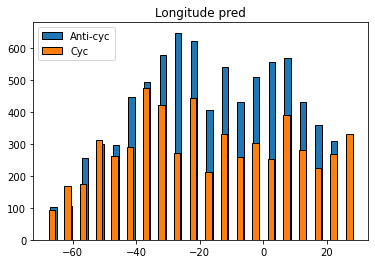

In [222]:
ax = plt.subplot(111)
ax.bar(data_arr_lon_pred_a[0], data_arr_lon_pred_a[1], width=2, ec="k", align="center", label = "Anti-cyc")
ax.bar(data_arr_lon_pred_c[0], data_arr_lon_pred_c[1], width=2, ec="k", align="center", label = "Cyc")
ax.legend()
ax.set_title('Longitude pred')

Text(0.5, 1.0, 'Longitude true')

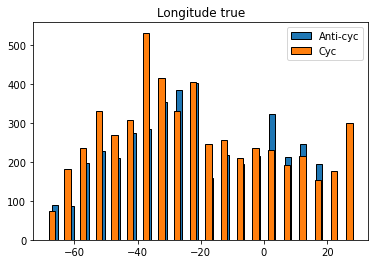

In [223]:
ax = plt.subplot(111)
ax.bar(data_arr_lon_true_a[0], data_arr_lon_true_a[1], width=2, ec="k", align="center", label = "Anti-cyc")
ax.bar(data_arr_lon_true_c[0], data_arr_lon_true_c[1], width=2, ec="k", align="center", label = "Cyc")
ax.legend()
ax.set_title('Longitude true')

Text(0.5, 1.0, 'Latitude pred')

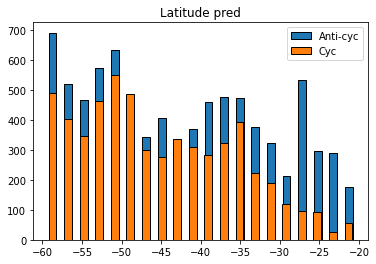

In [224]:
ax = plt.subplot(111)
ax.bar(data_arr_lat_pred_a[0], data_arr_lat_pred_a[1], width=1, ec="k", align="center", label = "Anti-cyc")
ax.bar(data_arr_lat_pred_c[0], data_arr_lat_pred_c[1], width=1, ec="k", align="center", label = "Cyc")
ax.legend()
ax.set_title('Latitude pred')

Text(0.5, 1.0, 'Latitude true')

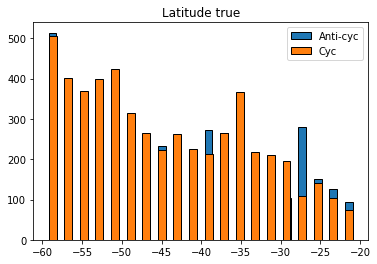

In [225]:
ax = plt.subplot(111)
ax.bar(data_arr_lat_true_a[0], data_arr_lat_true_a[1], width=1, ec="k", align="center", label = "Anti-cyc")
ax.bar(data_arr_lat_true_c[0], data_arr_lat_true_c[1], width=1, ec="k", align="center", label = "Cyc")
ax.legend()
ax.set_title('Latitude true')

In [227]:

#-40W to 5E, -40N

In [ ]:
"""
lon_reg = -70:1:30;
lat_reg = -60:1:-20;
lon = eddy_lon; lat = eddy_lat;
mean_radius = nan(len(lon),len(lat)); 
for ii = 1:len(lon_reg)-1 
    for jj = 1:len(lat_reg)-1 
        ind = lon>lon_reg(ii)&lon<lon_reg(ii+1)&lat>lat_reg(jj)&lat<lat_reg(jj+1); 
        mean_radius(ii,jj) = mean(radius(ind)); 
"""


In [ ]:
chopped_array = data.T[tuple(map(tuple, index_matrix.T))]


In [ ]:
chopped_array.mean()

In [ ]:
index_matrix[:,0].max()


In [ ]:
yy[index_matrix[:,0], index_matrix[:,1]]

In [ ]:
index_matrix[:,0]

In [ ]:
plt.plot(xx[index_matrix[:,0], index_matrix[:,1]], yy[index_matrix[:,0], index_matrix[:,1]], "o")

In [ ]:
data = ssh_data.grid_list[0].grid("ssh")

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_ylim((-60, -58))
ax.set_xlim((-68.5, -66))
ax.pcolormesh(x, y, ssh_data.T, cmap = cm.RdBu_r)
ax.plot(xx[index_matrix[:,0], index_matrix[:,1]], yy[index_matrix[:,0], index_matrix[:,1]], color='black')

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_ylim((-60, -58))
ax.set_xlim((-68.5, -66))
ax.contour(regular_grid.x_c, regular_grid.y_c, seg_data.T, (-1, 0, 1), cmap="rainbow")
plt.show()

In [ ]:
#Note for next time

#Check time next time for different section
#Solution for the time
#produce 1 year statistics for predicted and original
#Grid count and match functions
#Histogram for radius, Amp and speed
#mean and std original and predicted.
#